#### dcd_ch4_hw

# Homework for Chapter 4


In [1]:
#from math import exp
import matplotlib.pyplot as plt
import numpy as np
from PSP_heat import *
from PSP_thermalCond import *
from PSP_soil import *
from math import *
from PSP_heatSoil import*
from __future__ import division
from PSP_readDataFile import *
from PSP_grid import *
from PSP_ThomasAlgorithm import *

## Problem 1

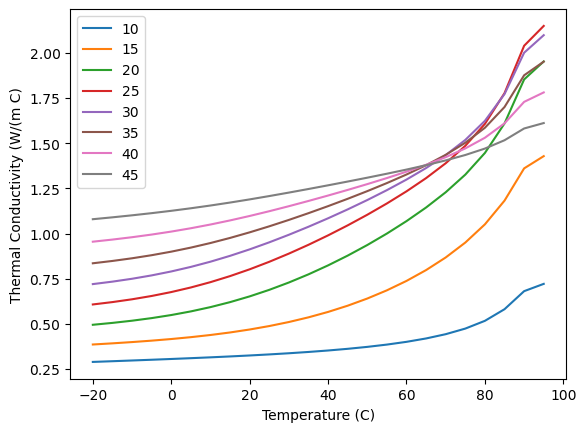

In [2]:
bulkDensity=1300
waterContent=range(10,50,5)
clay=.4
temperature = range(-20,100,5)
ypoints = []
theta_points = []
for y in waterContent:
    ypoints.append(y)
    xpoints =[]
    K_therm = []
    for x in temperature:
        K= thermalConductivity(bulkDensity, y/100 , clay, x)
        xpoints.append(x)
        K_therm.append(K)
    plt.plot(xpoints,K_therm,label = str(y))
plt.xlabel('Temperature (C)')
plt.ylabel('Thermal Conductivity (W/(m C)')
plt.legend((ypoints))

**At what temp is the K of wet soil independent of water content? Why?**

Through the investigation I conducted it would appear that for a wet soil that was 40% clay with a bulk density of $1.3 g cm^{-3}$ that the themal conductivity (K) becomes independent of water content around 70 &deg;C as that is where the differnt plots of K by water content begin to merge or at the very least cross. I believe this is caused by the laws used in the justification of the 1994 Campbell model. This model is based on the idea that the thermal conductivity of the soil is a weighted average of its constiiuent parts. So when the soil gets to roughly 70 &deg;C the conductivity of the soil gas, which is temperature dependent, becomes equivelent to or greater than the thermal conductivity of the soil water.

## Problem 2

In [3]:
theta=range(10,50,5)
bulk=range(1000,1500,50)
C_h = []
for x in bulk:
    for y in theta:
        C = heatCapacity(x,y/100)
        C_h.append(C)
max_C = max(C_h)/(10**6)
min_C = min(C_h)/(10**6)
print('maximum', max_C)
print('minimum', min_C)

maximum 3.1942075471698113
minimum 1.3236603773584905


**What is ths possible range of the specific heat in soil** (had 2 and 4 done but it deleted me back to this checkpiont so thats fun haha)

Since themal diffusivity is considered the conductivity over the specific heat the numerical range for specific heat could be any positive value. However the realistic answer would be that soils will only exhibit a volumetric heat capacity rougly between air ($0.00013 MJ m^{-3} K^{-1}$ ) and Water ($4.18 MJ m^{-3} K^{-1}$) with an average value close to that of mineral soils ($2.31 MJ m^{-3} K^{-1}$). We can simulate this further though with the help of the computer program above and find that a lower bound of $1.3 MJ m^{-3} K^{-1}$ and upper bound of $3.2 MJ m^{-3} K^{-1}$ are reasonable estimations of the volumetric heat capacitys for soils. 

$$ 1.3 MJ m^{-3} K^{-1} < C_h < 3.2 MJ m^{-3} K^{-1} $$

note: tried to call the actuall value using this syntax but I believe it does not support putting numbers in the text via this method :

$$ {{ max_C[0] }}$$

# Problem 3 
**predict temp as a function of time and depth**


FIN_DIFF = 1
CELL_CENT_FIN_VOL = 2

def initialize(T_0, thetaIni, solver):
    global z, dz, zCenter, vol, wc, T, oldT
    # vector depth [m]
    z = grid.geometric(n, 1.0)
  
    vol[0] = 0
    for i in range(n+1): 
        dz[i] = z[i+1]-z[i]
        if (i > 0): vol[i] = area * dz[i]
    for i in range(n+2): 
        zCenter[i] = z[i] + dz[i]*0.5
        
    if (solver == CELL_CENT_FIN_VOL):
        for i in range(n+1): 
            dz[i] = zCenter[i+1]-zCenter[i]
                 
    for i in range(1, n+2):
        T[i] = T_0
        oldT[i] = T_0
        wc[i] = thetaIni[i]               #Set water content with depth
    return z

def finiteDifference(airT, boundaryT, dt, factor):
    g = 1.0 - factor
    energyBalance = 1.
    for i in range(1, n+2):
        T[i] = oldT[i]
    nrIterations = 0
    while ((energyBalance > tolerance) and (nrIterations < maxNrIterations)):
        for i in range(1, n+2):
            #lambda_[0]= 20.
            lambda_[i] = thermalConductivity(bulkDensity, wc[i], clay, T[i])
            #print('Ktherm = ', lambda_[i])
            C_T[i] = heatCapacity(bulkDensity, wc[i])*vol[i]
        f[0] = 0.
        for i in range(1, n+1):
            f[i]=area* lambda_[i] / dz[i]
        for i in range(1, n+1):    
            if (i == 1):
                a[i] = 0.
                b[i] = 1.
                c[i] = 0.
                d[i] = airT
            elif (i < n):
                a[i] = -f[i-1]*factor
                b[i] = C_T[i]/dt + f[i-1]*factor + f[i]*factor
                c[i] = -f[i]*factor
                d[i] = C_T[i]/dt * oldT[i] +(1.-factor)*(f[i-1]*oldT[i-1]+f[i]
                                            *oldT[i+1]-(f[i-1]+f[i])*oldT[i])
            elif (i == n):
                a[n] = 0.
                b[n] = 1.
                c[n] = 0.
                d[n] = boundaryT 
        ThomasBoundaryCondition(a, b, c, d, T, 1, n)
        dSum = 0
        for i in range(2, n):
            dSum += C_T[i]*(T[i]-oldT[i])
        energyBalance = (abs(dSum - factor*dt*(f[1]*(T[1]-T[2]) 
                    - f[n-1]*(T[n-1]-boundaryT)) - g*dt*(f[1]*(oldT[1]-oldT[2]) 
                    - f[n-1]*(oldT[n-1]-boundaryT))))
        nrIterations += 1
        
    if (energyBalance < tolerance):
        flux = f[1]*(T[1]-T[2])
        return True, nrIterations, flux
    else:
        return False, nrIterations, 0


global z
print (FIN_DIFF, 'Finite Difference')
print (CELL_CENT_FIN_VOL, 'Cell-Centered Finite Volume')

solver = 1
tmp = 0.3
thetaIni = np.linspace(tmp, tmp, n+2)  #"water content (m^3/m^3): " 
meanT = 25 # "mean temperature [C]: " 
ampT = 5# "amplitude of change in temperature [C]: " 
omega = 2.0 * np.pi/(24 * 3600.0)
airT0 = meanT
timeShift = 8                       

if (solver == FIN_DIFF):
    factor = 0  #(0: explicit, 1: implicit Euler) = " 
    
    z = initialize(airT0, thetaIni, solver)
    simulationLenght = 72 #hours         #############################
                    
    endTime = simulationLenght * 3600.0         
    timeStepMax = 3600.0                        
    dt = timeStepMax / 8.0                      
    time = 0.0                                  
    sumHeatFlux = 0
    totalIterationNr = 0

f, plot = plt.subplots(3, figsize=(8,8), dpi=80)
plt.subplots_adjust(hspace = 0.3)
plot[1].set_xlabel("Time [h]",fontsize=14,labelpad=2)  
plot[1].set_ylabel("Temperature [C]",fontsize=14,labelpad=4)
plot[2].set_xlabel("Time [h]",fontsize=14,labelpad=2)
plot[2].set_ylabel("Heat flux [W m$^{-2}$]",fontsize=14,labelpad=4)
plot[1].set_xlim(timeShift, simulationLenght+timeShift)
plot[1].set_ylim(meanT-ampT, meanT+ampT)
plot[2].set_xlim(timeShift, simulationLenght+timeShift)

#Define output file
outFile= open("output.csv","a")
#Write header with depth
outFile.write("time [hr], 0.0 [m], 0.1 [m], 0.3 [m]\n")    

while (time < endTime):
    dt = min(dt, endTime - time)
    airT = airT0 + ampT * np.sin((time+dt)*omega)
    if (solver == FIN_DIFF):
        success, nrIterations, heatFlux = (
            finiteDifference(airT, meanT, dt, factor))            
    elif (solver == CELL_CENT_FIN_VOL):
        success, nrIterations, heatFlux = (
            cellCentFiniteVol(airT, meanT, dt))
    totalIterationNr += nrIterations
    
    
    if success:
        #Convergence achieved
        for i in range(n+1):
            oldT[i] = T[i]
        sumHeatFlux += heatFlux * dt 
        time += dt
        
        t = time/3600. + timeShift
        
        plot[0].clear()
        plot[0].set_xlabel("Temperature [C]",fontsize=14,labelpad=2)
        plot[0].set_ylabel("Depth [m]",fontsize=14,labelpad=4) 
        plot[0].set_xlim(meanT-ampT, meanT+ampT) 
        plot[0].plot(T[1:len(T)], -z[1:len(T)], 'k')
        plot[0].plot(T[1:len(T)], -z[1:len(T)], 'ko')
        plot[1].plot(t, T[getLayerIndex(z, 0.0)], 'ko')    
        plot[1].plot(t, T[getLayerIndex(z, 0.1)], 'ks')     
        plot[1].plot(t, T[getLayerIndex(z, 0.3)], 'k^')    
        plot[2].plot(t, heatFlux, 'ko')
        plt.pause(0.0001)
        #increment time step when system is converging
        if (float(nrIterations/maxNrIterations) < 0.25): 
                dt = min(dt*2, timeStepMax)
        #print(heat.T[getLayerIndex(heat.z, 0.15)])
        #save to file, the number after z is the selected depth        
        outFile.write("%.3f,%.3f,%.3f,%.3f,\n" %(t,T[getLayerIndex(z, 0.0)],T[getLayerIndex(z, 0.1)],T[getLayerIndex(z, 0.3)]))


    else:
        #No convergence
        dt = max(dt / 2, 1)
        for i in range(n+1): T[i] = oldT[i]
        print ("dt =", dt, "No convergence")
        break

outFile.close()
print("nr of iterations per hour:", totalIterationNr / simulationLenght)
#plt.ioff()
plt.show()


**how would residue effect soil temp**

An addition of residue could change many factors relating to the soils thermal properties. If the mulch were of a darker color this could increase absorbition of more energy in light causing an incresed amplitude of the surface temperature due to rapid heating. The opposite could be said of lighter residue considering an increase in albedo. Also, considering the Volumetric heat capacity of OM is higher than the soil minerals, a high OM peat moss mulch would likely need more energy to increase in temperature than it had previously resulting in less drastic temperature changes.

**at what depth is the sine wave 180 degrees out of phase with the surface** (trough peak overlap)


I dont know because I cant get this program to work properly and have given in to its continual beat down of my abilities (haha). 

However judging off of Figure 4.6 I would believe that it occurs closer to the 15 cm depth, possibly around 10 cm if I was to estimate the value.

# Problem 4 
**make PSP_heat change water content with depth**

Text(0, 0.5, 'Depth [m]')

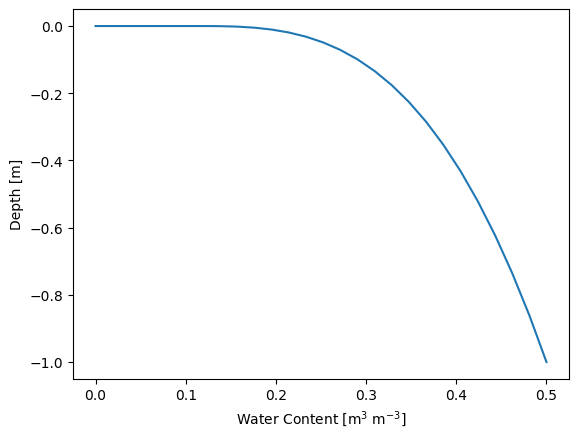

In [4]:


def initialize(T_0, thetaIni, solver):
    global z, dz, zCenter, vol, wc, T, oldT
    # vector depth [m]
    z = grid.geometric(n, 1.0)
  
    vol[0] = 0
    for i in range(n+1): 
        dz[i] = z[i+1]-z[i]
        if (i > 0): vol[i] = area * dz[i]
    for i in range(n+2): 
        zCenter[i] = z[i] + dz[i]*0.5
        
    if (solver == CELL_CENT_FIN_VOL):
        for i in range(n+1): 
            dz[i] = zCenter[i+1]-zCenter[i]
                 
    for i in range(1, n+2):
        T[i] = T_0
        oldT[i] = T_0
        wc[i] = thetaIni[i]               #Set water content with depth
    return z

def finiteDifference(airT, boundaryT, dt, factor):
    g = 1.0 - factor
    energyBalance = 1.
    for i in range(1, n+2):
        T[i] = oldT[i]
    nrIterations = 0
    while ((energyBalance > tolerance) and (nrIterations < maxNrIterations)):
        for i in range(1, n+2):
            #lambda_[0]= 20.
            lambda_[i] = thermalConductivity(bulkDensity, wc[i], clay, T[i])
            #print('Ktherm = ', lambda_[i])
            C_T[i] = heatCapacity(bulkDensity, wc[i])*vol[i]
        f[0] = 0.
        for i in range(1, n+1):
            f[i]=area* lambda_[i] / dz[i]
        for i in range(1, n+1):    
            if (i == 1):
                a[i] = 0.
                b[i] = 1.
                c[i] = 0.
                d[i] = airT
            elif (i < n):
                a[i] = -f[i-1]*factor
                b[i] = C_T[i]/dt + f[i-1]*factor + f[i]*factor
                c[i] = -f[i]*factor
                d[i] = C_T[i]/dt * oldT[i] +(1.-factor)*(f[i-1]*oldT[i-1]+f[i]
                                            *oldT[i+1]-(f[i-1]+f[i])*oldT[i])
            elif (i == n):
                a[n] = 0.
                b[n] = 1.
                c[n] = 0.
                d[n] = boundaryT 
        ThomasBoundaryCondition(a, b, c, d, T, 1, n)
        dSum = 0
        for i in range(2, n):
            dSum += C_T[i]*(T[i]-oldT[i])
        energyBalance = (abs(dSum - factor*dt*(f[1]*(T[1]-T[2]) 
                    - f[n-1]*(T[n-1]-boundaryT)) - g*dt*(f[1]*(oldT[1]-oldT[2]) 
                    - f[n-1]*(oldT[n-1]-boundaryT))))
        nrIterations += 1
        
    if (energyBalance < tolerance):
        flux = f[1]*(T[1]-T[2])
        return True, nrIterations, flux
    else:
        return False, nrIterations, 0

area = 1                    	
maxNrIterations = 100
tolerance = 1.e-2               
T_0 = 25                                  #Assumed initial temperature
n = 20                        
z = np.zeros(n+2, float)  
zCenter = np.zeros(n+2, float)      
dz = np.zeros(n+2, float)       
vol = np.zeros(n+2, float)     
wc = np.zeros(n+2, float)       
a = np.zeros(n+2, float)        
b = np.zeros(n+2, float)        
c = np.zeros(n+2, float)        
d = np.zeros(n+2, float)       

T = np.zeros(n+2, float)      
dT = np.zeros(n+2, float)       
oldT = np.zeros(n+2, float)     
C_T = np.zeros(n+2, float)     
lambda_ = np.zeros(n+2, float)  
k_mean = np.zeros(n+2, float)   
f = np.zeros(n+2, float)       
solver = 2
thetaIni = np.linspace(0.1, 0.5, n+2)  

initialize(T_0, thetaIni, solver)
hours = 72
finiteDifference(T_0, 20, hours *3600, 2 )
plt.figure
plt.plot(wc,-z)
plt.xlabel('Water Content [m$^{3}$ m$^{-3}$]')
plt.ylabel('Depth [m]')


[25.         25.         24.99764827 24.99153361 24.97977191 24.96046365
 24.9316501  24.89119956 24.8365586  24.7642649  24.66905677 24.54229987
 24.36922007 24.12394188 23.76027213 23.19382878 22.26580784 20.66621738
 17.76395151 12.21339405  1.         25.        ]


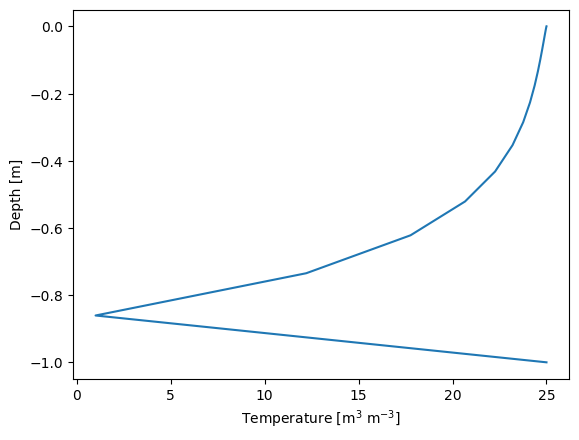

In [9]:
#changing theta

T[0] = T_0
plt.figure
plt.plot(T,-z)
plt.xlabel('Temperature [m$^{3}$ m$^{-3}$]')
plt.ylabel('Depth [m]')

print(T)

[25.         25.         24.99412647 24.97885488 24.94948197 24.9012833
 24.82945692 24.72897927 24.59429327 24.41870489 24.19330227 23.90511152
 23.53402711 23.04772043 22.39307337 21.48135972 20.1616725  18.17130843
 15.0390021   9.88681029  1.         25.        ]


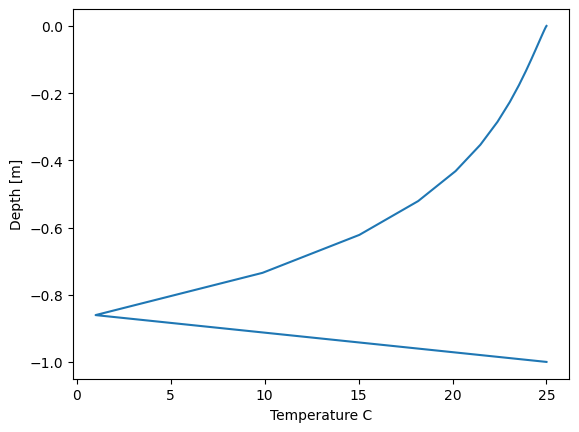

In [10]:
#constant dry theta
thetaIni = np.linspace(0.01, 0.01, n+2) 
initialize(T_0, thetaIni, solver)
hours = 72
finiteDifference(T_0, 1, hours *3600, 2)
T[0] = T_0
plt.figure
plt.plot(T,-z)
plt.xlabel('Temperature C')
plt.ylabel('Depth [m]')

print(T)


Im not sure if I have the function working exactly due to issues with the boundary conditions but we can see that the soil with a dry surface, which gets more wet as depth increases, has a much steeper slope of temperature than the completely dry soil. This higher rate of change is due to the higher concentration of water. ??

# Problem 5
**print temp at 15 and 30 cm**

after working on this for close to an hour I got it woking but have come to the realization that this does not calculate for a depth component. Did the authors mean "main 2" and if so that should be an edit explored in the book because it is very vauge. I cant get anything from main 2 and if I could the question doesnt specify at what time it would want the temp for the simulation. The numbers output at the bottom are in relation to the created graph though and come from the recorded soil temperatures at the 10cm and 25 cm depths.

Temperatures =  [20.3, 20.4, 19.8, 18.0]


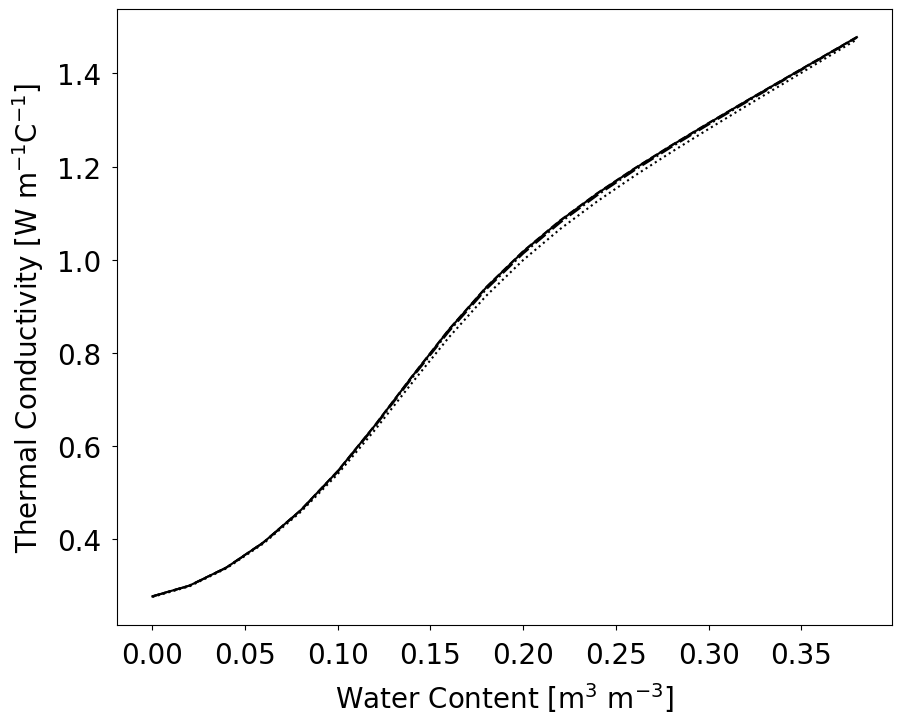

soil temp at 10 cm 20.3
soil temp at 25 cm 20.4


In [11]:
bulkDensity = 1600 # "bulk density [kg/m^3]: "
clay = .3 # "clay [0 - 1]: "

A, isFileOk = readDataFile("soilTemperatures_hours.csv", 1, ',', False)

soilTemperature = [A[0][1],A[0][2],A[0][3],A[0][4]] #10 25 70 135 cm
print ("Temperatures = ", soilTemperature)
nrTemperatures = len(soilTemperature)

particleDensity = 2650
porosity = 1 - (bulkDensity / particleDensity) 

step = 0.02  
nrValues = int(porosity / step) + 1
waterContent = np.zeros(nrValues)
thermalConductivitys = np.zeros(nrValues)  ###########after an hour. rename this as it is the name of the command as well
for i in range(nrValues):
    waterContent[i] = step*i


fig = plt.figure(figsize=(10,8))
plt.xlabel('Water Content [m$^{3}$ m$^{-3}$]',fontsize=20,labelpad=8)
plt.ylabel('Thermal Conductivity [W m$^{-1}$C$^{-1}$]',fontsize=20,labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=20,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=20,pad=8)
#plt.xlim(0, 0.7)
for t in range(nrTemperatures):
    for i in range(nrValues):
        thermalConductivitys[i] = thermalConductivity(bulkDensity, waterContent[i], clay, soilTemperature[t])
    if (t == 0): plt.plot(waterContent, thermalConductivitys,'k')  
    if (t == 1): plt.plot(waterContent, thermalConductivitys,'--k')   
    if (t == 2): plt.plot(waterContent, thermalConductivitys,'-.k') 
    if (t == 3): plt.plot(waterContent, thermalConductivitys,':k')
plt.show() 
print ('soil temp at 10 cm' , soilTemperature[0])
print ('soil temp at 25 cm' , soilTemperature[1])

Temperatures =  [20, 50, 70, 90]


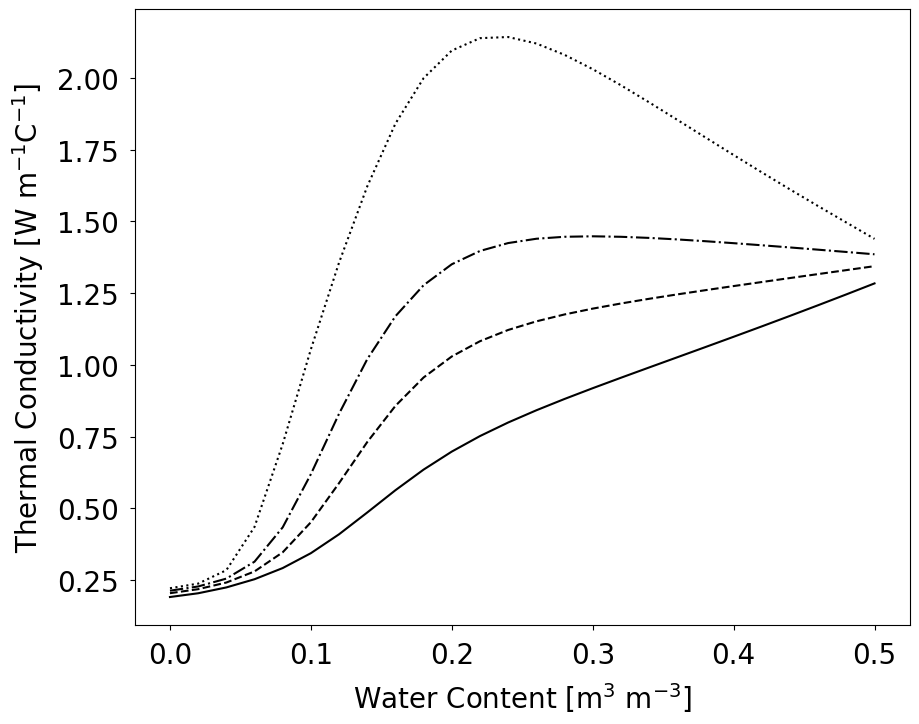

In [12]:
#fun example of wide temp


bulkDensity = 1300 # "bulk density [kg/m^3]: "
clay = .3 # "clay [0 - 1]: "

soilTemperature = [20,50,70,90] #10 25 70 135 cm
print ("Temperatures = ", soilTemperature)
nrTemperatures = len(soilTemperature)

particleDensity = 2650
porosity = 1 - (bulkDensity / particleDensity) 

step = 0.02  
nrValues = int(porosity / step) + 1
waterContent = np.zeros(nrValues)
thermalConductivitys = np.zeros(nrValues)  ###########after an hour. rename this as it is the name of the command as well
for i in range(nrValues):
    waterContent[i] = step*i


fig = plt.figure(figsize=(10,8))
plt.xlabel('Water Content [m$^{3}$ m$^{-3}$]',fontsize=20,labelpad=8)
plt.ylabel('Thermal Conductivity [W m$^{-1}$C$^{-1}$]',fontsize=20,labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=20,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=20,pad=8)
#plt.xlim(0, 0.7)
for t in range(nrTemperatures):
    for i in range(nrValues):
        thermalConductivitys[i] = thermalConductivity(bulkDensity, waterContent[i], clay, soilTemperature[t])
    if (t == 0): plt.plot(waterContent, thermalConductivitys,'k')  
    if (t == 1): plt.plot(waterContent, thermalConductivitys,'--k')   
    if (t == 2): plt.plot(waterContent, thermalConductivitys,'-.k') 
    if (t == 3): plt.plot(waterContent, thermalConductivitys,':k')
plt.show() 

# Problem 6

**modify clay and bulk of soil.py and investigate the effect of these variables on soil temp at 3 textures and 2 densities**

PSP_Soil is all hydraulic based so I believe the author means heatsoil
also, did they mean thermal conductivity?
I feel like in this set of questions the problems were a bit vague or under explained but that could be more a lack of understanding how to code this on my part

In [13]:
Db= [1500,900]
clay= [0.1,0.3,0.7]
theta = 0.3
temp = 25

for i in Db:
    for j in clay:
        K = thermalConductivity(i, theta, j, temp)
        print('bulk density = ', i, ' clay = ', j, ' conductivity = ', K) 
        

bulk density =  1500  clay =  0.1  conductivity =  1.1905622999739145
bulk density =  1500  clay =  0.3  conductivity =  1.1862159732171547
bulk density =  1500  clay =  0.7  conductivity =  1.1213825252006733
bulk density =  900  clay =  0.1  conductivity =  0.6278320949527835
bulk density =  900  clay =  0.3  conductivity =  0.621795424005874
bulk density =  900  clay =  0.7  conductivity =  0.5352751195379998


As clay content increased the thermal conductivity decreased. In the higher clay soils this means the temperature would have changed more easily, requireing less energy to do so.

In the compacted soil the conductivity was almost double that of the freshly tilled soil, likely due to the increased porosity and thus air volume. When theta is increased there is much less difference between the two for that reason.

# Problem 7
**modify PSP Heat investigate the effects of the 3 types of solutions**


In [5]:
def cellCentFiniteVol(airT, boundaryT, dt):
    energyBalance = 1.
    for i in range(1, n+2):
        T[i] = oldT[i] 
    nrIterations = 0
    while ((energyBalance > tolerance) and (nrIterations < maxNrIterations)):
        for i in range(1, n+2):
            lambda_[i] = thermalConductivity(bulkDensity, wc[i], clay, T[i])
            C_T[i] = heatCapacity(bulkDensity, wc[i])*vol[i]
        f[0] = 0.
        for i in range(1, n+1):
            f[i] = area * kMean(LOGARITHMIC, lambda_[i], lambda_[i+1]) / dz[i]
        for i in range(1, n+1):    
            if (i == 1):
                a[i] = 0.
                b[i] = 1.
                c[i] = 0.
                d[i] = airT
            elif (i < n):
                a[i] = -f[i-1]
                b[i] = C_T[i]/dt + f[i-1] + f[i]
                c[i] = -f[i]
                d[i] = C_T[i]/dt * oldT[i]
            elif (i == n):
                a[n] = 0.
                b[n] = 1.
                c[n] = 0.
                d[n] = boundaryT 
        ThomasBoundaryCondition(a, b, c, d, T, 1, n)
        dSum = 0
        for i in range(2, n):
            dSum += C_T[i]*(T[i]-oldT[i])
        energyBalance = (abs(dSum - f[1]*(T[1]-T[2])*dt 
                           + f[n-1]*(T[n-1]-boundaryT)*dt))
        nrIterations += 1
        
    if (energyBalance < tolerance):
        flux = f[1]*(T[1]-T[2])
        return True, nrIterations, flux
    else:
        return False, nrIterations, 0
    

In [6]:
thetaIni = np.linspace(0.01, 0.01, n+2) 
initialize(T_0, thetaIni, 1)
hours = 72
finiteDifference(T_0, 1, hours *3600, 2)
T[0] = T_0

print('finite explicit')
print(T)

finite explicit
[25.         25.         24.99722314 24.98611555 24.96112123 24.91667
 24.84713295 24.74669873 24.60909044 24.42699723 24.19102947 23.88790677
 23.4974158  22.98735437 22.30505198 21.3627993  20.0119373  17.99489836
 14.85247028  9.7355388   1.         25.        ]


In [7]:
thetaIni = np.linspace(0.01, 0.01, n+2) 
initialize(T_0, thetaIni, 1)
hours = 72
finiteDifference(T_0, 1, hours *3600, 1)
T[0] = T_0
print('finite implicit')
print(T)

finite implicit
[25.         25.         24.99882957 24.99414779 24.98361241 24.96487081
 24.93552396 24.89302438 24.83443966 24.75597221 24.65206111 24.51377765
 24.32599857 24.06236513 23.67600925 23.08177279 22.12056362 20.48466528
 17.55420579 12.0228041   1.         25.        ]


In [8]:
thetaIni = np.linspace(0.01, 0.01, n+2) 
initialize(T_0, thetaIni, 2)
hours = 72
cellCentFiniteVol(T_0, 1, hours *3600)
T[0] = T_0
print('Crank-Nicholson')
print(T)


Crank-Nicholson
[25.         25.         24.99764827 24.99153361 24.97977191 24.96046365
 24.9316501  24.89119956 24.8365586  24.7642649  24.66905677 24.54229987
 24.36922007 24.12394188 23.76027213 23.19382878 22.26580784 20.66621738
 17.76395151 12.21339405  1.         25.        ]


Again, I am not sure if the code is properly working in this case but we can see that the temperature values decrease with depth in all three cases. the finite explicit has less of a curve to its values, exhibiting steep decrease with depth while the Crank-Nicholson method has a deep 'trough' before the temperature begins to decrease, essentially saying the top depth doesnt cool as quickly.

The implicit selection similarly maintains the initial temperature but not as much as the Crank method.

note on this project: sorry this is so shodily put together Dr. Ochsner but this one gave me some real trouble trying to get the code working and I am not sure how I could have improved the code better. Again I apolozie for this lacking report and problem 3 was a complete wash in my book haha.